# FaceMask Detection and Classification

This project will be an analysis of a dataset from Kaggle ["https://www.kaggle.com/aditya276/face-mask-dataset-yolo-format"] that gives images of people wearing (and not wearing) facemasks belonging to three classes as well as their bounding box. The goal of this project is to implement the YOLO Algorithm from 

## Libraries

In [1]:
import os
import random
import PIL
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
import csv
import cv2

## Preview Data

In [2]:
trainDir = os.path.join(os.getcwd(), "archive\\dataset\\images\\train")
validationDir = os.path.join(os.getcwd(), "archive\\dataset\\images\\valid")
testDir = os.path.join(os.getcwd(), "archive\\dataset\\images\\test")

print(f"There are {len(os.listdir(trainDir))/2} training examples")
print(f"There are {len(os.listdir(validationDir))/2} validation examples")
print(f"There are {len(os.listdir(testDir))/2} test examples")

There are 700.0 training examples
There are 100.0 validation examples
There are 120.0 test examples


In [3]:
def drawBoundingBoxes(fpath):
    """
    Take in the filepath of an image or text file, retreive the image and bounding box information, and 
    draw the bounding box over the image. Returns an image
    """ 
    
    # Reformat the filepath to incldue the path to the image and YOLO information
    fpath = os.path.splitext(fpath)[0]
    fpathImage = fpath + ".jpg"
    fpathBB = fpath + ".txt"
    
    # Retrieve the image
    try:
        image = np.array(PIL.Image.open(fpathImage))
    except FileNotFoundError:
        try:
            fpathImage =  fpath + ".jpeg"
            image = np.array(PIL.Image.open(fpathImage))
        except FileNotFoundError:
            fpathImage =  fpath + ".png"
            image = np.array(PIL.Image.open(fpathImage)) 
    
    height, width, depth = image.shape
    
    #Initialize YOLO variables
    classification = []
    yMid = []
    xMid = []
    ylen = []
    xlen = []
    
    # Open CSV File
    with open(fpathBB) as csvfile:
        
        #Format CSV file into rows
        reader = csv.reader(csvfile, delimiter=" ")
        
        #For each row, extract the required data
        for row in reader:
            classification.append(float(row[0]))
            xMid.append(float(row[1]))
            yMid.append(float(row[2]))
            xlen.append(float(row[3]))
            ylen.append(float(row[4]))
    
    
    # Draw each bounding box
    for i in range(len(classification)):
            
        # Reframe YOLO format into start and end points
        xMiddle = round(width * xMid[i])
        yMiddle = round(height * yMid[i])
        xlength = round(width * xlen[i])
        ylength = round(height * ylen[i])
        
        startpoint = (xMiddle - xlength, yMiddle - ylength)
        endpoint =   (xMiddle + xlength, yMiddle + xlength)   
        
        # Color red for no mask and green for mask
        if classification[i] > 0.5:
            color = (0,255,0)
        else:
            color = (255,0,0)
        
        # Determine thickness based on image size
        longSide = np.max((width, height))
        thickness = round(longSide * 0.003)
        
        # Draw the bounding box
        image = cv2.rectangle(image, startpoint, endpoint, color, thickness)
    
    return image

def previewImage(directory=trainDir):
    """
    Preview an image within the training directory, can be applied to other images
    """
    
    # Get a List of files within the given directory
    files = os.listdir(directory)
    
    # Choose a random file
    fileName = random.sample(files, 1)[0]
    
    # Create filepath
    fpath = os.path.join(directory, fileName)
    
    # Draw bounding boxes over the image
    image = drawBoundingBoxes(fpath)
    
    plt.imshow(image)

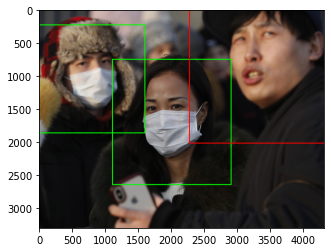

In [17]:
previewImage()

## Data Generator

For most TensorFlow implementations with images, using ImageDataGenerator is a quick and easy way to handle training data. It handles data augmentation techniques, connecting training examples to their labels, and it's a one-liner... hard to beat for the simple cases; however for implementing YOLO, the label for a given training example isn't simply defined as the file's location. Rather, there is a seperate text file that includes the YOLO format of bounding box. To coordinate the connection of training examples and their labels, we will need to implement a custom data generator.

In [10]:
class YOLODataGen(tf.keras.utils.Sequence):
    
    # Initialize self variables
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(250,250,3),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_name = df[y_col['name']].nunique()
        self.n_type = df[y_col['type']].nunique()
        
    def on_epoch_end(self):
        pass
    
    def __getitem__(self, index):
        pass
    
    def __len__(self):
        return self.
    
    
        